In [29]:
# train_finetune.py — put in ~/project_ai/
import os
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# (ensure you include the code to create train_generator/test_generator exactly as in your notebook)

# --- LOAD DATA GENERATORS (copy your exact generator config) ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "../dataset/Train"
test_dir  = "../dataset/Test"
IMG_SIZE = (224,224)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                                   horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=32, class_mode='categorical')
test_generator  = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=32, class_mode='categorical', shuffle=False)

# --- LOAD model (your best pretrained or earlier saved model) ---
model = load_model("notebook/best_model.keras")  # or whichever base model file you want

# --- Optional: unfreeze last N layers (copy the unfreeze logic you used) ---
from tensorflow.keras.layers import GlobalAveragePooling2D
N_unfreeze = 40
pool_idx = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, GlobalAveragePooling2D):
        pool_idx = i
        break
if pool_idx is None:
    print("pool not found, use manual unfreeze")
else:
    base_end_idx = pool_idx
    for layer in model.layers[:base_end_idx]:
        layer.trainable = False
    start_unfreeze = max(0, base_end_idx - N_unfreeze)
    for layer in model.layers[start_unfreeze:base_end_idx]:
        layer.trainable = True
    for layer in model.layers[base_end_idx:]:
        layer.trainable = True

# --- compile ---
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- class weights ---
counts = Counter(train_generator.classes)
total = sum(counts.values())
num_classes = len(counts)
class_weights = {cls: total/(num_classes * cnt) for cls, cnt in counts.items()}

# --- callbacks ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('notebook/best_model_finetuned_v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# --- fit and save ---
history = model.fit(train_generator, validation_data=test_generator, epochs=12,
                    class_weight=class_weights, callbacks=callbacks)
model.save("notebook/best_model_finetuned_last.keras")


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


ValueError: File not found: filepath=notebook/best_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [28]:
# ---------- callbacks & class weights ----------
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# compute simple class weights from the train generator
counts = Counter(train_generator.classes)
total = sum(counts.values())
num_classes = len(counts)
class_weights = {cls: total/(num_classes * cnt) for cls, cnt in counts.items()}
print("train counts:", counts)
print("class_weights:", class_weights)

# callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('notebook/best_model_finetuned_v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# ---------- fit ----------
history_ft = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=8,                 # start small, increase if val improves
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# save final weights (optional, checkpoint will already save best)
model.save("notebook/best_model_finetuned_last.keras")

# quick evaluation
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\nFinal test acc: {acc:.4f}, loss: {loss:.4f}")


train counts: Counter({np.int32(0): 65534, np.int32(2): 46781, np.int32(1): 39334})
class_weights: {np.int32(0): 0.7713502405875831, np.int32(1): 1.2851392349282216, np.int32(2): 1.0805597714171709}


/home/madhavan_1502/tfenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8326 - loss: 0.3952
Epoch 1: val_accuracy improved from None to 0.66280, saving model to notebook/best_model_finetuned_v2.keras
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 801s 166ms/step - accuracy: 0.8648 - loss: 0.3377 - val_accuracy: 0.6628 - val_loss: 1.0206 - learning_rate: 1.0000e-05
Epoch 2/8
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9113 - loss: 0.2390
Epoch 2: val_accuracy improved from 0.66280 to 0.76020, saving model to notebook/best_model_finetuned_v2.keras
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 718s 151ms/step - accuracy: 0.9160 - loss: 0.2255 - val_accuracy: 0.7602 - val_loss: 0.7293 - learning_rate: 1.0000e-05
Epoch 3/8
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9269 - loss: 0.1951
Epoch 3: val_accuracy did not improve from 0.76020
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 713s 150ms/step - accuracy: 0.9299 - loss: 0.1873 - val_accuracy: 0.7277 - val_loss: 0.8667 - learning_rate: 1.0000e-05
Epoch 4/8


In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D

# How many base layers to unfreeze
N_unfreeze = 40   # tweak later (20..80)

# Find pooling layer (boundary) automatically
pool_idx = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, GlobalAveragePooling2D):
        pool_idx = i
        break

if pool_idx is None:
    print("Pool layer not found automatically. Run model.summary() and choose boundary index.")
    model.summary()
else:
    base_end_idx = pool_idx
    print("Found pooling layer at index:", pool_idx, " => base layers are 0..", base_end_idx-1)

    # Freeze all base layers first
    for layer in model.layers[:base_end_idx]:
        layer.trainable = False

    # Unfreeze the last N_unfreeze base layers
    start_unfreeze = max(0, base_end_idx - N_unfreeze)
    for layer in model.layers[start_unfreeze:base_end_idx]:
        layer.trainable = True

    # Ensure head layers (pooling + dense) are trainable
    for layer in model.layers[base_end_idx:]:
        layer.trainable = True

    # Report boundary region
    print(f"Unfreezing base layers {start_unfreeze} .. {base_end_idx-1}")
    for i in range(max(0, start_unfreeze-3), base_end_idx+3):
        try:
            print(i, model.layers[i].name, "trainable=", model.layers[i].trainable)
        except IndexError:
            pass

    # Recompile with a small learning rate
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    print("Recompiled model for fine-tuning (lr=1e-5)")


Found pooling layer at index: 154  => base layers are 0.. 153
Unfreezing base layers 114 .. 153
111 block_12_depthwise_BN trainable= False
112 block_12_depthwise_relu trainable= False
113 block_12_project trainable= False
114 block_12_project_BN trainable= True
115 block_12_add trainable= True
116 block_13_expand trainable= True
117 block_13_expand_BN trainable= True
118 block_13_expand_relu trainable= True
119 block_13_pad trainable= True
120 block_13_depthwise trainable= True
121 block_13_depthwise_BN trainable= True
122 block_13_depthwise_relu trainable= True
123 block_13_project trainable= True
124 block_13_project_BN trainable= True
125 block_14_expand trainable= True
126 block_14_expand_BN trainable= True
127 block_14_expand_relu trainable= True
128 block_14_depthwise trainable= True
129 block_14_depthwise_BN trainable= True
130 block_14_depthwise_relu trainable= True
131 block_14_project trainable= True
132 block_14_project_BN trainable= True
133 block_14_add trainable= True
134

In [26]:
import tensorflow as tf
# find first sub-model (MobileNetV2) inside your model
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
        base_model = layer
        break

if base_model is None:
    print("Couldn't find sub-model in model.layers, show model.summary() and pick the base manually.")
else:
    print("Found base model:", base_model.name)
    # unfreeze last N layers
    N = 40
    for layer in base_model.layers[:-N]:
        layer.trainable = False
    for layer in base_model.layers[-N:]:
        layer.trainable = True

    # recompile with small LR
    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # fine-tune
    history_ft = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=8,
        class_weight=class_weights,   # if using class weights
        callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
                   EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                   ModelCheckpoint('notebook/best_model_finetuned_v2.keras', save_best_only=True, monitor='val_accuracy')]
    )


Couldn't find sub-model in model.layers, show model.summary() and pick the base manually.


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.18,
    height_shift_range=0.18,
    shear_range=0.12,
    zoom_range=0.18,
    brightness_range=(0.7,1.2),
    horizontal_flip=False,   # keep if it makes sense for text (probably not)
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)


Found 151649 images belonging to 3 classes.


In [24]:
# run inside your notebook (after creating train_generator)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y = train_generator.classes                          # array of class indices
classes = np.unique(y)                               # e.g. [0,1,2]
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weights = {int(cls): float(w) for cls, w in zip(classes, cw)}
print("class_weights:", class_weights)

# pass to model.fit:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)


class_weights: {0: 0.7713502405875831, 1: 1.2851392349282216, 2: 1.0805597714171709}
Epoch 1/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 711s 149ms/step - accuracy: 0.7885 - loss: 0.4615 - val_accuracy: 0.5726 - val_loss: 1.0688 - learning_rate: 1.2500e-06
Epoch 2/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7897 - loss: 0.4611
Epoch 2: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 654s 138ms/step - accuracy: 0.7889 - loss: 0.4619 - val_accuracy: 0.5749 - val_loss: 1.0570 - learning_rate: 1.2500e-06
Epoch 3/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 651s 137ms/step - accuracy: 0.7886 - loss: 0.4590 - val_accuracy: 0.5707 - val_loss: 1.0854 - learning_rate: 6.2500e-07


In [23]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


1773/1773 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.5708 - loss: 1.0820
✅ Test Accuracy: 0.5708, Test Loss: 1.0820


In [22]:
model.save("best_model_finetuned_balanced.keras")



In [20]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    epochs=15,
    callbacks=[lr_scheduler, early_stop, checkpoint],
    class_weight=class_weights    # <---- add this line
)


Epoch 1/15
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 772s 163ms/step - accuracy: 0.7850 - loss: 0.4677 - val_accuracy: 0.5708 - val_loss: 1.0820 - learning_rate: 2.5000e-06
Epoch 2/15
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7880 - loss: 0.4627
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 743s 157ms/step - accuracy: 0.7878 - loss: 0.4634 - val_accuracy: 0.5794 - val_loss: 1.0722 - learning_rate: 2.5000e-06
Epoch 3/15
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 735s 155ms/step - accuracy: 0.7889 - loss: 0.4588 - val_accuracy: 0.5659 - val_loss: 1.1190 - learning_rate: 1.2500e-06


In [19]:
from collections import Counter

# Class counts from your data
counts = Counter({0: 65534, 2: 46781, 1: 39334})
total = sum(counts.values())
num_classes = len(counts)

# Compute balanced class weights
class_weights = {cls: float(total / (num_classes * cnt)) for cls, cnt in counts.items()}
print("Calculated class weights:", class_weights)



Calculated class weights: {0: 0.7713502405875831, 2: 1.0805597714171709, 1: 1.2851392349282216}


In [18]:
print(train_generator.class_indices)
from collections import Counter
print(Counter(train_generator.classes))


{'Corrected': 0, 'Normal': 1, 'Reversal': 2}
Counter({np.int32(0): 65534, np.int32(2): 46781, np.int32(1): 39334})


In [17]:
print("class_indices:", train_generator.class_indices)
from collections import Counter
print("class counts from generator:", Counter(train_generator.classes))


class_indices: {'Corrected': 0, 'Normal': 1, 'Reversal': 2}
class counts from generator: Counter({np.int32(0): 65534, np.int32(2): 46781, np.int32(1): 39334})


In [15]:
import os
from collections import Counter

train_dir = "../dataset/Train"
counts = {}
for label in os.listdir(train_dir):
    p = os.path.join(train_dir, label)
    if os.path.isdir(p):
        counts[label] = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p,f))])
print("Folder counts:", counts)

# Map label names -> integer indices used by generator
# If you already created train_generator you'll want to use train_generator.class_indices to map names -> indices
label_to_index = train_generator.class_indices  # e.g. {'Corrected':0, 'Normal':1, 'Reversal':2}
print("Label->index:", label_to_index)

# Build counts by index
counts_by_index = { label_to_index[name]: cnt for name, cnt in counts.items() }
total = sum(counts_by_index.values())
num_classes = len(counts_by_index)
class_weights = {idx: float(total / (num_classes * cnt)) for idx, cnt in counts_by_index.items()}
print("Class weights (by index):", class_weights)


Folder counts: {'Normal': 39334, 'Corrected': 65534, 'Reversal': 46781}
Label->index: {'Corrected': 0, 'Normal': 1, 'Reversal': 2}
Class weights (by index): {1: 1.2851392349282216, 0: 0.7713502405875831, 2: 1.0805597714171709}


In [14]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=[lr_scheduler, early_stop, checkpoint],
    class_weight=class_weights
)


Epoch 1/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 718s 149ms/step - accuracy: 0.7809 - loss: 0.4776 - val_accuracy: 0.5861 - val_loss: 0.9981 - learning_rate: 5.0000e-06
Epoch 2/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7844 - loss: 0.4679
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 645s 136ms/step - accuracy: 0.7860 - loss: 0.4669 - val_accuracy: 0.5588 - val_loss: 1.1603 - learning_rate: 5.0000e-06
Epoch 3/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 645s 136ms/step - accuracy: 0.7880 - loss: 0.4592 - val_accuracy: 0.5787 - val_loss: 1.0908 - learning_rate: 2.5000e-06


In [13]:
import numpy as np
from collections import Counter

# ensure train_generator exists and has .classes
counts = Counter(train_generator.classes)   # {0: n0, 1: n1, 2: n2}
print("Counts:", counts)

total = sum(counts.values())
num_classes = len(counts)

# balanced weight: total / (num_classes * count_i)
class_weights = {cls: float(total / (num_classes * cnt)) for cls, cnt in counts.items()}
print("Class weights:", class_weights)


Counts: Counter({np.int32(0): 65534, np.int32(2): 46781, np.int32(1): 39334})
Class weights: {np.int32(0): 0.7713502405875831, np.int32(1): 1.2851392349282216, np.int32(2): 1.0805597714171709}


In [11]:
import os
from collections import Counter

def count_images(path):
    counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images("../dataset/Train")
test_counts  = count_images("../dataset/Test")

print("Train set:", train_counts)
print("Test set :", test_counts)


Train set: {'Normal': 39334, 'Corrected': 65534, 'Reversal': 46781}
Test set : {'Normal': 19557, 'Corrected': 19284, 'Reversal': 17882}


In [10]:
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[lr_scheduler, early_stop, checkpoint]
)


Epoch 1/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 705s 149ms/step - accuracy: 0.7724 - loss: 0.4684 - val_accuracy: 0.5858 - val_loss: 0.9808 - learning_rate: 1.0000e-05
Epoch 2/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7809 - loss: 0.4495
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 650s 137ms/step - accuracy: 0.7823 - loss: 0.4467 - val_accuracy: 0.5765 - val_loss: 1.0014 - learning_rate: 1.0000e-05
Epoch 3/10
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 678s 143ms/step - accuracy: 0.7895 - loss: 0.4270 - val_accuracy: 0.5809 - val_loss: 1.0475 - learning_rate: 5.0000e-06


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Paths to your dataset
train_dir = "../dataset/Train"
test_dir  = "../dataset/Test"

# ✅ Image and batch settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data augmentation (for training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ✅ Only rescale for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # slower LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ Model recompiled for fine-tuning.")


✅ Model recompiled for fine-tuning.


In [5]:
# Unfreeze all layers first
for layer in model.layers:
    layer.trainable = True

# Freeze everything except the last 40 layers
for layer in model.layers[:-40]:
    layer.trainable = False

print("✅ Unfroze last 40 layers for fine-tuning.")


✅ Unfroze last 40 layers for fine-tuning.


In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load your best saved model (from previous training)
model = load_model("best_model.keras")

print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)
model = Model(base_model.input, output)

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model you saved earlier
model = load_model("best_model.keras")   # or "final_model.keras"

# Re-compile with your fine-tuning learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model reloaded and compiled successfully.")


I0000 00:00:1760203345.034198     907 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model reloaded and compiled successfully.


In [ ]:
# First make all layers trainable
for layer in model.layers:
    layer.trainable = True

# Then freeze everything except last 40 layers
for layer in model.layers[:-40]:
    layer.trainable = False


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 input_layer <class 'keras.src.layers.core.input_layer.InputLayer'>
1 Conv1 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
2 bn_Conv1 <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
3 Conv1_relu <class 'keras.src.layers.activations.relu.ReLU'>
4 expanded_conv_depthwise <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
5 expanded_conv_depthwise_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
6 expanded_conv_depthwise_relu <class 'keras.src.layers.activations.relu.ReLU'>
7 expanded_conv_project <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
8 expanded_conv_project_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
9 block_1_expand <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
10 block_1_expand_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
11 block_1_expand_relu <class 'keras.src.layers.activations.relu.Re

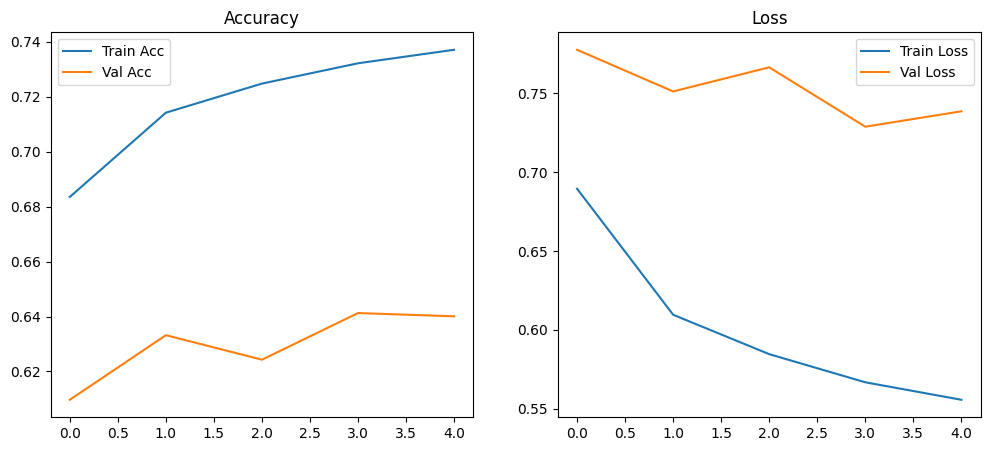

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,   # start small (5–10 epochs)
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

#Baseline Training (Frozen MobileNetV2)

Epoch 1/5


2025-09-24 08:19:06.944551: I external/local_xla/xla/service/service.cc:163] XLA service 0x72688803da60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-24 08:19:06.944581: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-24 08:19:07.022483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-24 08:19:07.538235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-24 08:19:07.665961: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-24 08:19:08.

3000/4740 ━━━━━━━━━━━━━━━━━━━━ 4:06 142ms/step - accuracy: 0.6420 - loss: 0.7818

2025-09-24 08:26:29.686847: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 08:26:29.953777: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 08:26:30.110034: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 08:26:30.282351: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 08:26:30.440543: E external/local_xla/xla/stream_

4740/4740 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6554 - loss: 0.7526

/home/madhavan_1502/tfenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-24 08:31:23.510957: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 08:31:23.688367: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4740/4740 ━━━━━━━━━━━━━━━━━━━━ 742s 153ms/step - accuracy: 0.6835 - loss: 0.6895 - val_accuracy: 0.6097 - val_loss: 0.7776 - learning_rate: 1.0000e-04
Epoch 2/5
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 660s 139ms/step - accuracy: 0.7142 - loss: 0.6096 - val_accuracy: 0.6332 - val_loss: 0.7512 - learning_rate: 1.0000e-04
Epoch 3/5
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 658s 139ms/step - accuracy: 0.7248 - loss: 0.5846 - val_accuracy: 0.6243 - val_loss: 0.7664 - learning_rate: 1.0000e-04
Epoch 4/5
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 655s 138ms/step - accuracy: 0.7322 - loss: 0.5668 - val_accuracy: 0.6413 - val_loss: 0.7288 - learning_rate: 1.0000e-04
Epoch 5/5
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 653s 138ms/step - accuracy: 0.7371 - loss: 0.5557 - val_accuracy: 0.6401 - val_loss: 0.7386 - learning_rate: 1.0000e-04


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Base model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze layers initially

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)  # 3 classes

# Build final model
model = Model(base_model.input, output)

# Compile
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

model.summary()


I0000 00:00:1758701502.042522   27616 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Just rescale for testing
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


2025-09-24 08:09:47.921404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 08:09:48.265344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 08:09:50.388981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [ ]:
# Dataset paths (relative to your notebook folder)
train_dir = "../dataset/Train"
test_dir  = "../dataset/Test"

import os

# Print class folders to verify dataset structure
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['Normal', 'Corrected', 'Reversal']
Test classes: ['Normal', 'Corrected', 'Reversal']


In [ ]:
# Unfreeze last 40 layers of the full model
for layer in model.layers[:-40]:
    layer.trainable = False

for layer in model.layers[-40:]:
    layer.trainable = True

# Re-compile with smaller LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))



0 input_layer_3 <class 'keras.src.layers.core.input_layer.InputLayer'>
1 Conv1 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
2 bn_Conv1 <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
3 Conv1_relu <class 'keras.src.layers.activations.relu.ReLU'>
4 expanded_conv_depthwise <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
5 expanded_conv_depthwise_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
6 expanded_conv_depthwise_relu <class 'keras.src.layers.activations.relu.ReLU'>
7 expanded_conv_project <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
8 expanded_conv_project_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
9 block_1_expand <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
10 block_1_expand_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
11 block_1_expand_relu <class 'keras.src.layers.activations.relu.

In [ ]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


2025-09-23 16:23:39.912363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 16:23:40.211405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 16:23:42.324725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TF version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


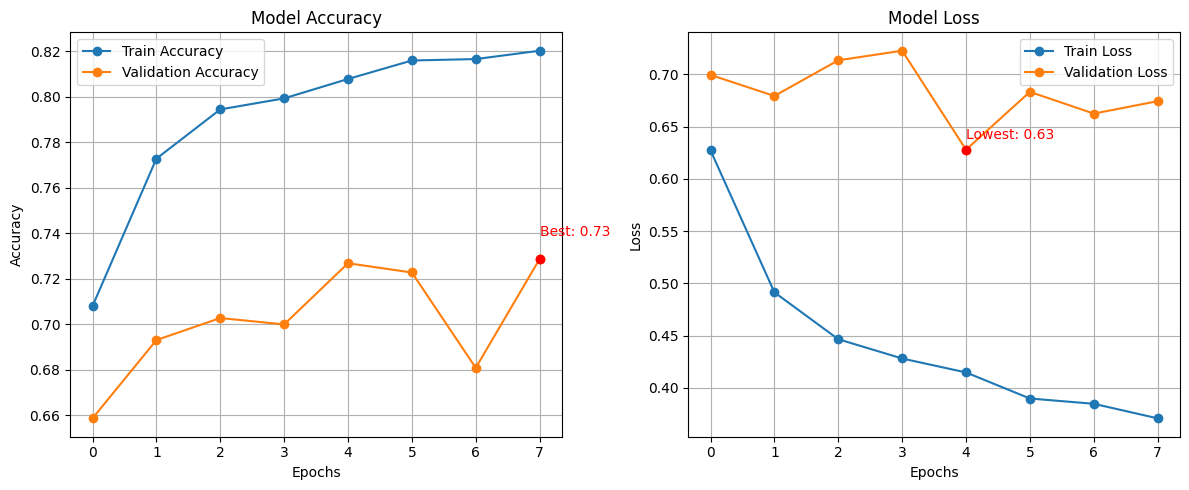

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy plot
best_acc_epoch = np.argmax(history.history['val_accuracy'])
best_acc = history.history['val_accuracy'][best_acc_epoch]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.scatter(best_acc_epoch, best_acc, color='red', zorder=5)
plt.text(best_acc_epoch, best_acc+0.01, f'Best: {best_acc:.2f}', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
best_loss_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_loss_epoch]

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.scatter(best_loss_epoch, best_loss, color='red', zorder=5)
plt.text(best_loss_epoch, best_loss+0.01, f'Lowest: {best_loss:.2f}', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
weights='imagenet'
input_shape=(224,224,3)
color_mode='rgb'


In [ ]:
from PIL import Image
import os

train_dir = r"C:\Users\madha\OneDrive\Desktop\project ai\dataset\Train"

for subdir, dirs, files in os.walk(train_dir):
    for file in files[:5]:  # check first 5 images
        filepath = os.path.join(subdir, file)
        img = Image.open(filepath)
        print(file, img.mode)  # should print "RGB"


4_1.png RGB
4_10.png RGB
4_100.png RGB
4_1000.png RGB
4_1001.png RGB
A-0.png RGB
A-1.png RGB
A-10.png RGB
A-1000.png RGB
A-1001.png RGB
1_1.png RGB
1_10.png RGB
1_100.png RGB
1_1000.png RGB
1_10000.png RGB


In [ ]:
weights='imagenet'
input_shape=(224,224,3)
color_mode='rgb'


In [ ]:
from PIL import Image
import os

def convert_to_rgb(folder):
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            filepath = os.path.join(subdir, file)
            img = Image.open(filepath)
            if img.mode != 'RGB':
                img = img.convert('RGB')
                img.save(filepath)

convert_to_rgb(r"C:\Users\madha\OneDrive\Desktop\project ai\dataset\Train")
convert_to_rgb(r"C:\Users\madha\OneDrive\Desktop\project ai\dataset\Test")


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',   # important
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',   # important
    batch_size=32,
    shuffle=False
)


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [ ]:
print("Train dir:", os.path.abspath(train_dir))
print("Test dir:", os.path.abspath(test_dir))


Train dir: c:\Users\madha\OneDrive\Desktop\project ai\dataset\Train
Test dir: c:\Users\madha\OneDrive\Desktop\project ai\dataset\Test


In [ ]:
base_dir = r"../dataset"


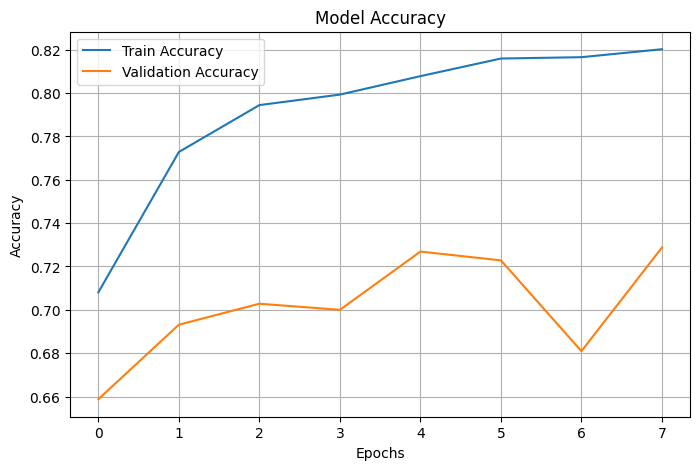

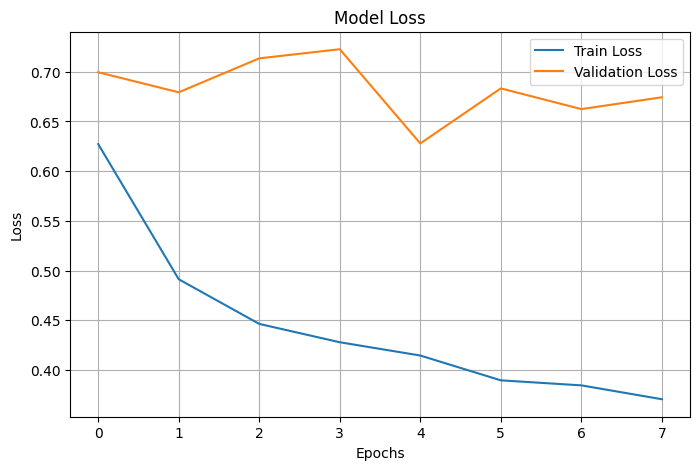

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
loss, acc = model.evaluate(test_generator)  # full 56k test images
print(f"Final Test Accuracy: {acc:.2f}")


887/887 ━━━━━━━━━━━━━━━━━━━━ 259s 291ms/step - accuracy: 0.7061 - loss: 0.6582
Final Test Accuracy: 0.71


In [ ]:
loss, acc = model.evaluate(test_generator, steps=200)  # ~12k test images
print(f"Quick Test Accuracy: {acc:.2f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.7008 - loss: 0.6728
Quick Test Accuracy: 0.70


In [ ]:
# Data
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=64
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=64
)

# Model (transfer learning)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze for speed

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(base_model.input, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=200,   # only 200 batches → ~12,800 images per epoch
    validation_steps=50,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


c:\Users\madha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 728ms/step - accuracy: 0.7080 - loss: 0.6273 - val_accuracy: 0.6587 - val_loss: 0.6995
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 707ms/step - accuracy: 0.7728 - loss: 0.4914 - val_accuracy: 0.6931 - val_loss: 0.6793
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 135s 677ms/step - accuracy: 0.7945 - loss: 0.4465 - val_accuracy: 0.7028 - val_loss: 0.7135
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 620ms/step - accuracy: 0.7993 - loss: 0.4280 - val_accuracy: 0.7000 - val_loss: 0.7227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 591ms/step - accuracy: 0.8078 - loss: 0.4147 - val_accuracy: 0.7269 - val_loss: 0.6279
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 107s 537ms/step - accuracy: 0.8159 - loss: 0.3897 - val_accuracy: 0.7228 - val_loss: 0.6833
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 102s 512ms/step - accuracy: 0.8166 - loss: 0.3847 - val_accuracy: 0.6809 - val_loss: 0.6625
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 96s 483ms/step - accuracy: 0.8202 - 

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load MobileNetV2 as base (exclude top layers)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base layers

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#Build Model (MobileNetV2 Transfer Learning)
#Since you already have a big dataset, we are starting with Transfer Learning (MobileNetV2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # 3 classes
)

# Testing Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


#Data Generators , We’ll use augmentation only for training.

Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [ ]:
# Paths (relative to your notebook folder)
train_dir = "../dataset/Train"
test_dir  = "../dataset/Test"

# Config
IMG_SIZE = (224, 224)   # resize to 224x224
BATCH_SIZE = 16
EPOCHS = 20


#define path and config

In [ ]:
# ---- BASIC IMPORTS ----
import os
import numpy as np
import matplotlib.pyplot as plt

# ---- TENSORFLOW / KERAS ----
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#Setup and imports